# Semantica QA Framework for Knowledge Discovery from CORD-19

Installing and importing packages

In [ ]:
# install packages
!pip install nltk 
!pip install owlready2 
!pip install pronto 
!pip install ipynb-py-convert 
!pip install langdetect 
!pip install contractions 
!pip install inflect
!pip install num2words
!pip install tables
!pip install h5py
!pip install sentence-transformers 
!pip install pandas 
!pip install tqdm 
!pip install seaborn 
!pip install numpy 
!pip install scipy 
!pip install matplotlib 
!pip install numpy 
!pip install bottleneck 
!pip install pandarallel 
!pip install wordcloud 
!pip install spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


In [2]:
from collections import defaultdict
import glob
import itertools
import json
import pickle
import os
import re
import bs4
import contractions
import inflect
from langdetect import detect
import matplotlib.pyplot as plt
import networkx as nx
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from PIL import Image
import requests
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from spacy.matcher import Matcher
from spacy.tokens import Span
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Initialize pandarallel
pandarallel.initialize(use_memory_fs=False,nb_workers=2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# pandas options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.options.mode.chained_assignment = None 

tqdm.pandas()

## Data Loading

In [5]:
# Help functions and class
# help function to generate file path
def filepath(*args):
    if len(args) < 1:
        return None
    elif len(args) == 1:
        return args[0]
    else:
        return f'{args[0]}/{filepath(*args[1:])}'

# Add time bar to loop
def addtimebar(L, threshold=1000):
    if len(L) > threshold:
        return tqdm(L)
    else:
        return L

# File Reader Class
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            try:
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            except KeyError:
                pass
                    
            # Body text
            try:
                for entry in content['body_text']:
                    self.body_text.append(entry['text'])
            except KeyError:
                pass
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

# Helper function adds break after every words when character length reach to certain amount. This is for the interactive plot so that hover tool fits the screen.
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

## composition function
## example: compose(f1,f2,f3)(x, y) = f3(f2(f1(x, y)))
def compose(*funcs):
    *funcs, penultimate, last = funcs
    if funcs:
        penultimate = compose(*funcs, penultimate)
    return lambda *args: penultimate(last(*args))

In [6]:
# file path
path = "/content/drive/My Drive/Thesis"
meta = "metadata.csv"
# path for all json files
all_jsons = glob.glob(filepath(path, '**', '*.json'), recursive=True)

In [7]:
# dataframe for meta data
meta_df = pd.read_csv(filepath(path, meta),
                      dtype={'pubmed_id': str,
                             'Microsoft Academic Paper ID': str,
                             'doi': str,
                             'journal':str
                             },
                     low_memory=False)

In [8]:
# Load the text data into DataFrame
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'publish_time':[], 'journal': [], 'abstract_summary': []}
for entry in addtimebar(all_jsons):
    content = FileReader(entry)
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['paper_id'].append(content.paper_id)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 300 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add publish time
    try:
        publish_time = get_breaks(meta_data['publish_time'].values[0], 40)
        dict_['publish_time'].append(publish_time)
    # if publish time was not provided
    except Exception as e:
        dict_['publish_time'].append(meta_data['publish_time'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title',  'journal', 'publish_time', 'abstract_summary'])
df_covid.head()

In [9]:
# save data
df_covid.to_pickle('/content/drive/My Drive/Thesis/df_all.pkl')
# # load saved data
# with open('/content/drive/My Drive/Thesis/df_all.pkl', 'rb') as fp:
#    df_covid = pickle.load(fp)

In [10]:
print(len(df_covid)) # number of lines in df_covid
# look at the top 3 rows in the dataframe
df_covid.head(3)

58396


,paper_id,abstract,body_text,authors,title,journal,publish_time,abstract_summary
0,2ad337f148249bbc7fa34527302927081cd36d31,To aid the ongoing battle against hospital-acq...,The emergence of the severe acute respiratory ...,"Damji, S.. Barlow, G. D....",An audit of the use of isolation facilities i...,Journal of Hospital Infection,2005-07-31,To aid the ongoing battle against<br>hospital...
1,9e9aaaacb26e95ceec9d7465ce65972e1fd84a7a,The solar radiation can heat the building oute...,The environmental and public health issues are...,"Mu, Di. Gao, Naiping...",CFD investigation on the effects of wind and<...,Building and Environment,2018-06-30,The solar radiation can heat the building out...
2,55d762875ac9c5b43832336f3a88d0e70ff8ab9c,Background: Our recent meta-analysis indicated...,"In controlled trials, vitamin C has improved e...","Hemilä, Harri. Chalker, Elizabeth",Vitamin C may reduce the duration of mechanic...,J Intensive Care,2020-02-07,Background: Our recent meta-analysis<br>indic...


## Data Processing

### Select English articles

In [11]:
# function to check if text of certain column in dataframe is written in certain language 
def is_lang(row, item, lang, dropNA=True):
    if (row[item] != None and row[item] != '' and row[item] != 'None' and isinstance(row[item], str)):
        try:
            return detect(row[item]) == lang
        except Exception as e:
            #print("Non-readable entity will be droped from data.frame")
            return False
    else:
        return not dropNA

# select article written in certain language 
def select_article_lang_multi(df, basedon='abstract', lang='en'):
    return df[df.parallel_apply(lambda text: is_lang(text, basedon, lang), axis=1)]

df_covid_eng = select_article_lang_multi(df_covid)
print('Number of English Articles: {}/{}'.format(len(df_covid_eng), len(df_covid)))
df_covid_eng.head(n=2)

Number of English Articles: 40134/58396


,paper_id,abstract,body_text,authors,title,journal,publish_time,abstract_summary
0,2ad337f148249bbc7fa34527302927081cd36d31,To aid the ongoing battle against hospital-acq...,The emergence of the severe acute respiratory ...,"Damji, S.. Barlow, G. D....",An audit of the use of isolation facilities i...,Journal of Hospital Infection,2005-07-31,To aid the ongoing battle against<br>hospital...
1,9e9aaaacb26e95ceec9d7465ce65972e1fd84a7a,The solar radiation can heat the building oute...,The environmental and public health issues are...,"Mu, Di. Gao, Naiping...",CFD investigation on the effects of wind and<...,Building and Environment,2018-06-30,The solar radiation can heat the building out...


In [12]:
# save intermidiate data
df_covid_eng.to_pickle('../data/df_all_eng.pkl')
# load saved data
# with open('/content/drive/My Drive/Thesis/df_all_eng.pkl', 'rb') as fp:
#    df_covid_eng = pickle.load(fp)

In [13]:
print(len(df_covid_eng)) # number of lines in df_covid_eng
# look at the top 3 rows in the dataframe
df_covid_eng.head(3)

40134


,paper_id,abstract,body_text,authors,title,journal,publish_time,abstract_summary
0,2ad337f148249bbc7fa34527302927081cd36d31,To aid the ongoing battle against hospital-acq...,The emergence of the severe acute respiratory ...,"Damji, S.. Barlow, G. D....",An audit of the use of isolation facilities i...,Journal of Hospital Infection,2005-07-31,To aid the ongoing battle against<br>hospital...
1,9e9aaaacb26e95ceec9d7465ce65972e1fd84a7a,The solar radiation can heat the building oute...,The environmental and public health issues are...,"Mu, Di. Gao, Naiping...",CFD investigation on the effects of wind and<...,Building and Environment,2018-06-30,The solar radiation can heat the building out...
2,55d762875ac9c5b43832336f3a88d0e70ff8ab9c,Background: Our recent meta-analysis indicated...,"In controlled trials, vitamin C has improved e...","Hemilä, Harri. Chalker, Elizabeth",Vitamin C may reduce the duration of mechanic...,J Intensive Care,2020-02-07,Background: Our recent meta-analysis<br>indic...


### Text cleanning and tokenization


In [14]:
# Pre-processing functions
## text level processors
def replace_brackets_with_whitespace(text):
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace('[', '')
    text = text.replace(']', '')
    return text

def replace_contractions(text):
    return contractions.fix(text)

# remove special characters
def strip_characters(text):
    t = re.sub('\(|\)|:|,|;|\.|’||“|\?|%|>|<', '', text)
    t = re.sub('/', ' ', t)
    t = t.replace("'",'')
    return t

## word level processors:
def to_lowercase(word):
    return word.lower()

def do_stemming(stemmer):
    return lambda word: stemmer.stem(word)

def do_lemmatizing(lemmatizer):
    return lambda word: lemmatizer.lemmatize(word, pos='v') 

# help function to test if word is stopword
def is_stopword(word):
    return word in stopwords.words('english')

# function to process word
def process_word_by(word_cleanner, uniqueYN):
    def cond(word):
        return (len(word) > 1 and
                not is_stopword(word) and
                not word.isnumeric() and
                word.isalnum() and
                word != len(word) * word[0])

    def clean_byword(text):
        return list(take_unique(uniqueYN)((word_cleanner(word) for word in text if cond(word))))

    return clean_byword

# function to decide making a set (unique words) from text or not
def take_unique(YN):
    return set if YN else lambda x:x

# function to pre_processing the text
## compose text and word processors by combine every individual processor together 
text_processor = compose(replace_brackets_with_whitespace, replace_contractions, strip_characters)
word_processor = compose(to_lowercase, do_lemmatizing(WordNetLemmatizer()), do_stemming(PorterStemmer())) # it is crucial to do stemming after lemmatization

## pre_processing function taking a dataframe and text and word processor functions as input and clean the text and tokenize the specified column
def pre_processing(df, text_tools, word_tools):
    def inner(col, uniqueYN=False):
        return df[col].parallel_apply(text_tools).parallel_apply(nltk.word_tokenize).parallel_apply(process_word_by(word_tools,uniqueYN=uniqueYN))
    return inner

In [15]:
# sort by publish time
tokenized_df = df_covid_eng.sort_values(by='publish_time', ascending=False)
tokenized_df.head(n=3)

,paper_id,abstract,body_text,authors,title,journal,publish_time,abstract_summary
30894,7d3d591550199dfc1b1e818a2c4b93a3c91db83a,A B S T R A C T Analysis of bodily fluids usin...,Although concepts of biomedical applications o...,"Byrne, Hugh J.. Bonnier, Franck...",Quantitative analysis of human blood serum<br...,Clinical Spectroscopy,2020-12-31,A B S T R A C T Analysis of bodily fluids usi...
26049,a452fffd88c36ba02e3cbde8d2aa992b15290bbb,Colorimetric biosensors can be used to detect ...,An infectious virus particle is made up of nuc...,"Zhao, Victoria Xin Ting. Wong, Ten It...",Colorimetric biosensors for point-of-care<br>...,Materials Science for Energy Technologies,2020-12-31,Colorimetric biosensors can be used to detect...
39262,8697a9c71461dbf2fcbdb7e6c8459a3c5ffe080b,Based on its forensic capacity and experience ...,The International Committee of the Red Cross (...,"Finegan, Oran. Fonseca, Stephen...",International Committee of the Red Cross<br>(...,Forensic Science International: Synergy,2020-12-31,Based on its forensic capacity and experience...


In [16]:
# created processor function with chosen text and work processors and apply it to all articles to clean and tokenize all abstracts
processor = pre_processing(tokenized_df, text_processor, word_processor)
tokenized_df['abstract_token'] = processor('abstract')

# reset index (this is necessary for cosine similarity search)
tokenized_df = tokenized_df.reset_index(drop=True)

# Processor function is a generic procedure to clean and tokenize any column with user specified column name, such as 'abstract' or 'body_text'
# Because processing body_text takes too long, only process abstract
# tokenized_df['body_text_token'] = processor('body_text')

In [17]:
# store the dataframe 
tokenized_df.to_pickle('/content/drive/My Drive/Thesis/df_all_eng_tokenized.pkl')
# # open the dataframe
# with open('/content/drive/My Drive/Thesis/df_all_eng_tokenized.pkl', 'rb') as fp:
#    tokenized_df = pickle.load(fp)

# have a look at the head of the cleanned and tokenized abstract column
tokenized_df.head()['abstract_token']

0    [analysi, bodili, fluid, use, vibrat, spectros...
1    [colorimetr, biosensor, use, detect, particula...
2    [base, forens, capac, experi, gain, worldwid, ...
3    [homolog, human, viral, protein, establish, fa...
4    [hydrogen, technolog, fuel, cell, offer, alter...
Name: abstract_token, dtype: object

In [18]:
len(tokenized_df)

40134

In [19]:
# Due to RAM contraint, select the initial 25000 publications for further analysis
tokenized_df = tokenized_df[:25000]

In [20]:
tokenized_df.head()

,paper_id,abstract,body_text,authors,title,journal,publish_time,abstract_summary,abstract_token
0,7d3d591550199dfc1b1e818a2c4b93a3c91db83a,A B S T R A C T Analysis of bodily fluids usin...,Although concepts of biomedical applications o...,"Byrne, Hugh J.. Bonnier, Franck...",Quantitative analysis of human blood serum<br...,Clinical Spectroscopy,2020-12-31,A B S T R A C T Analysis of bodily fluids usi...,"[analysi, bodili, fluid, use, vibrat, spectros..."
1,a452fffd88c36ba02e3cbde8d2aa992b15290bbb,Colorimetric biosensors can be used to detect ...,An infectious virus particle is made up of nuc...,"Zhao, Victoria Xin Ting. Wong, Ten It...",Colorimetric biosensors for point-of-care<br>...,Materials Science for Energy Technologies,2020-12-31,Colorimetric biosensors can be used to detect...,"[colorimetr, biosensor, use, detect, particula..."
2,8697a9c71461dbf2fcbdb7e6c8459a3c5ffe080b,Based on its forensic capacity and experience ...,The International Committee of the Red Cross (...,"Finegan, Oran. Fonseca, Stephen...",International Committee of the Red Cross<br>(...,Forensic Science International: Synergy,2020-12-31,Based on its forensic capacity and experience...,"[base, forens, capac, experi, gain, worldwid, ..."
3,7220ce6df74c050673c37d340c06f7b94b6c7ced,Homology between human and viral proteins is a...,Autopsies of Chinese citizens who have died fr...,"Lyons-Weiler, James",Pathogenic priming likely contributes to<br>s...,Journal of Translational Autoimmunity,2020-12-31,Homology between human and viral proteins is ...,"[homolog, human, viral, protein, establish, fa..."
4,131244022c7f60fa4d34c09a5c1b62d4bfc77687,Hydrogen technologies and fuel cells offer an ...,Numerous countries across the world are now ur...,"Thomas, John Meurig. Edwards, Peter P....",Decarbonising energy: The developing<br>inter...,Journal of Energy Chemistry,2020-12-31,Hydrogen technologies and fuel cells offer an...,"[hydrogen, technolog, fuel, cell, offer, alter..."


## Data Exploration
### Word cloud


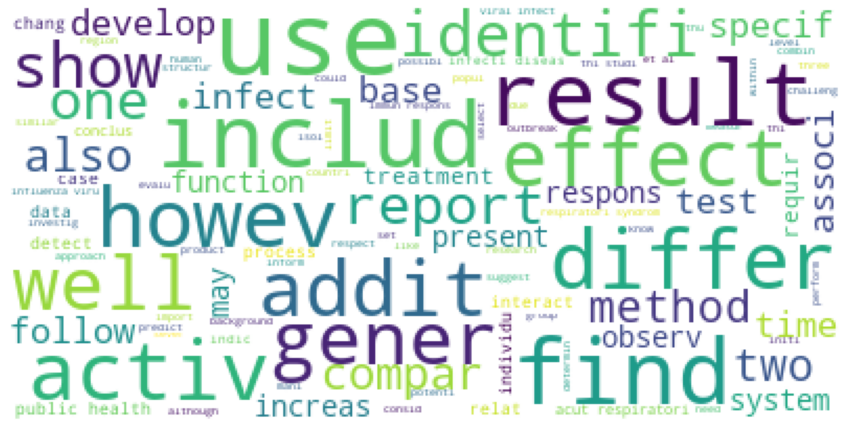

In [21]:
# create corpus
tokenized_df['abstract_corpus'] = tokenized_df['abstract_token'].apply(lambda tokens: ' '.join(tokens))
corpus = tokenized_df['abstract_corpus'].tolist()

#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords.words('english'),
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(' '.join(corpus))
fig = plt.figure(1)
fig.set_size_inches(15,12)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Visualizing top 20 uni-grams, bi-grams & tri-grams 


In [22]:
# Function to get top n-grams
def get_top_nK_words(corpus, K=1, n=None):
    vec1 = CountVectorizer(max_df=0.7,stop_words=stopwords.words('english'), ngram_range=(K,K),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

#### Top Uni-grams

[Text(0, 0, 'infect'),
 Text(0, 0, 'use'),
 Text(0, 0, 'patient'),
 Text(0, 0, 'studi'),
 Text(0, 0, 'diseas'),
 Text(0, 0, 'viru'),
 Text(0, 0, 'cell'),
 Text(0, 0, 'result'),
 Text(0, 0, 'model'),
 Text(0, 0, 'viral'),
 Text(0, 0, 'protein'),
 Text(0, 0, 'case'),
 Text(0, 0, 'respiratori'),
 Text(0, 0, 'sever'),
 Text(0, 0, 'effect'),
 Text(0, 0, 'data'),
 Text(0, 0, 'develop'),
 Text(0, 0, 'show'),
 Text(0, 0, 'human'),
 Text(0, 0, 'includ')]

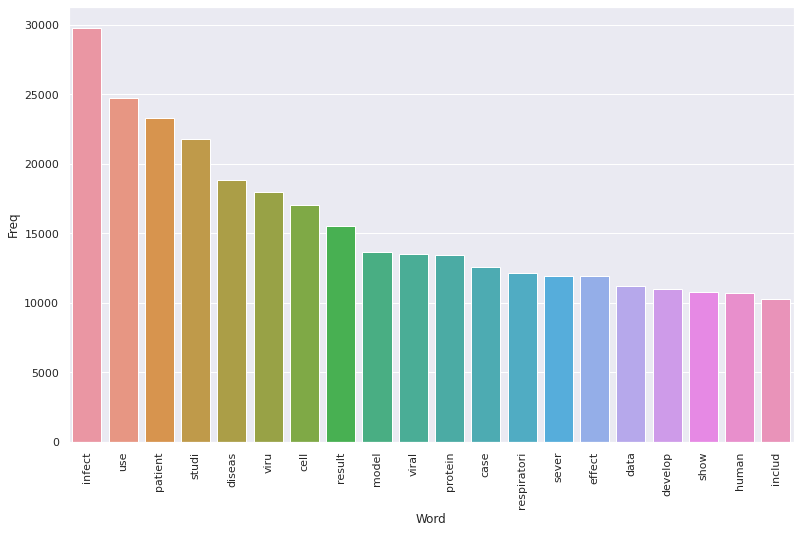

In [23]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_nK_words(corpus, K=1, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

#### Top Bi-grams

                Bi-gram  Freq
0         public health  2767
1      acut respiratori  2611
2        infecti diseas  2531
3   respiratori syndrom  2518
4         immun respons  2078
5          viral infect  1865
6            sever acut  1615
7     coronaviru diseas  1576
8           risk factor  1452
9    syndrom coronaviru  1439
10       influenza viru  1416
11    respiratori tract  1334
12     novel coronaviru  1285
13           middl east  1149
14          viru infect  1109
15           amino acid  1107
16       social distanc  1073
17          result show  1061
18          intens care   999
19    respiratori virus   998


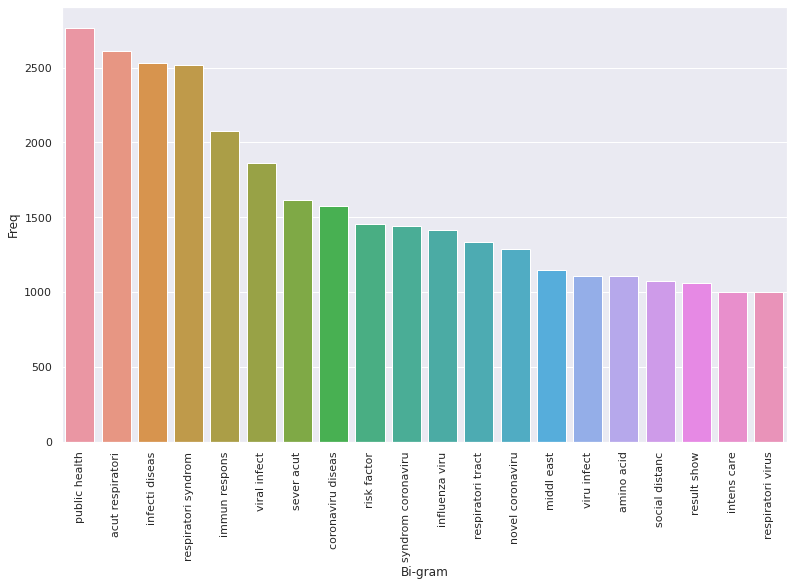

In [24]:
# Top bi-grams
top2_words = get_top_nK_words(corpus, K=2, n=23)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
top2_df = top2_df.drop([top2_df.index[5], top2_df.index[6], top2_df.index[16]]).reset_index(drop=True)
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90)
fig = h.get_figure()

#### Top Tri-grams

                          Tri-gram  Freq
0           sever acut respiratori  1546
1   respiratori syndrom coronaviru  1418
2         acut respiratori syndrom  1332
3           middl east respiratori   974
4         east respiratori syndrom   925
5         polymeras chain reaction   769
6                 intens care unit   719
7         respiratori syncyti viru   714
8         respiratori tract infect   701
9           porcin epidem diarrhea   491
10                play import role   480
11    respiratori distress syndrom   480
12       acut respiratori distress   464
13              world health organ   454
14                   thi studi aim   410
15            epidem diarrhea viru   387
16             author funder grant   379
17            funder grant medrxiv   379
18            grant medrxiv licens   379
19          medrxiv licens display   379


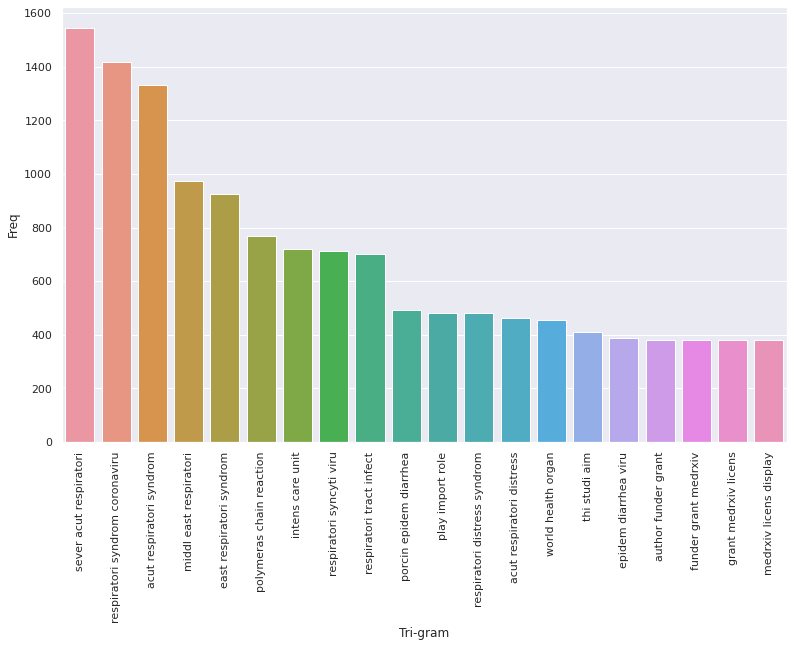

In [25]:
top3_words = get_top_nK_words(corpus, K=3, n=26)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
top3_df=top3_df.drop([top3_df.index[9], top3_df.index[10], top3_df.index[11], top3_df.index[18], top3_df.index[20], top3_df.index[21]]).reset_index(drop=True)
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=90)
fig = j.get_figure()

## Define Keywords and Query

Keywords:"ARS-CoV-2, Covid-19, HCoV-19, Covid corona, 2019-nCoV, sars, cov2, ncov wuhan, coronavirus, pneumonia"

Query for sentence embedding: "Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of SARS-CoV-2, including, but not limited to, possible cardiomyopathy and cardiac arrest.".


## Vectorization

TF-IDF

Implement a search engine based on TF-IDF and cosine similarity with bag of word model. 

### Compute TF-IDF scores for word vectors
Compute TF-IDF scores based on word vectors

In [ ]:
# compute TF-IDF scores for word vectors
def tfidf_(df):
    myvectorizer = TfidfVectorizer()
    vectors = myvectorizer.fit_transform(df['abstract_token'].parallel_apply(lambda x:' '.join(x))).toarray()
    feature_names = myvectorizer.get_feature_names()
    veclist = vectors.tolist()
    out_tfidf = pd.DataFrame(veclist, columns=feature_names)
    return out_tfidf

tfidf_(tokenized_df[:20]).head()

### Finding words with highest TF-IDF scores in the vectors


In [27]:
# extract key-words with tfidf score
tfidf_scores_df = tfidf_(tokenized_df[:20])
N = 15 # Number of min/max values 
u = np.argpartition(tfidf_scores_df, axis=1, kth=N).values
v = tfidf_scores_df.columns.values[u].reshape(u.shape)
maxdf = pd.DataFrame(v[:,-N:]).rename(columns=lambda x: f'Max{x+1}')
maxdf.head()

,Max1,Max2,Max3,Max4,Max5,Max6,Max7,Max8,Max9,Max10,Max11,Max12,Max13,Max14,Max15
0,administ,adjust,adequ,address,addit,acut,act,aceinhibitor,accumul,account,accord,year,access,abstract,à3
1,admiss,administ,adjust,adequ,address,addit,acut,act,aceinhibitor,accumul,account,accord,access,abstract,à3
2,administ,adjust,adequ,address,addit,acut,act,aceinhibitor,worldwid,accumul,account,accord,access,abstract,à3
3,admiss,administ,adjust,adequ,address,addit,acut,act,aceinhibitor,accumul,account,accord,access,abstract,à3
4,adjust,adequ,address,wind,without,addit,acut,act,aceinhibitor,accumul,account,accord,access,abstract,à3


## Filtering articles based on Keywords

### Implementing a search engine with cosine similarity based on the TF-IDF scores


In [28]:
# convert query token to vector
def gen_vector_T(tokens):
    Q = np.zeros((len(vocabulary)))    
    x= tfidf.transform(tokens)
    #print(tokens[0].split(','))
    for token in tokens[0].split(','):
        #print(token)
        try:
            ind = vocabulary.index(token)
            Q[ind]  = x[0, tfidf.vocabulary_[token]]
        except:
            pass
    return Q

# calculate cosine similarity
def cosine_sim(a, b):
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    return cos_sim

# Function to get transformed tfidf model
def tfidf_tran(mydf):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(mydf['abstract_token'].parallel_apply(lambda x:' '.join(x)))
    return vectors

# Define wordLemmatizer
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
def wordLemmatizer(data):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    file_clean_k =pd.DataFrame()
    for index,entry in enumerate(data):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in nltk.pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if len(word)>1 and word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
            # The final processed set of words for each iteration will be stored in 'text_final'
                file_clean_k.loc[index,'Keyword_final'] = str(Final_words).lower()
                file_clean_k=file_clean_k.replace(to_replace ="\[.", value = '', regex = True)
                file_clean_k=file_clean_k.replace(to_replace ="'", value = '', regex = True)
                file_clean_k=file_clean_k.replace(to_replace =" ", value = '', regex = True)
                file_clean_k=file_clean_k.replace(to_replace ='\]', value = '', regex = True)
    return file_clean_k

In [29]:
def cosine_similarity_T(k, query, text_token_df):
    preprocessed_query  = re.sub("\W+", " ", query).strip()
    tokens = nltk.word_tokenize(text_processor(str(preprocessed_query).lower()))
    tokens = [word_processor(token) for token in tokens if 
              len(token) > 1 and
              not is_stopword(token) and
              not token.isnumeric() and
              token.isalnum() and
              token != len(token) * token[0]]
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =tokens
    q_df['q_clean'] = wordLemmatizer(q_df.q_clean)
    d_cosines = []
    #print(q_df['q_clean'])
    query_vector = gen_vector_T(q_df['q_clean'])
    #print(query_vector)
    #print(q_df['q_clean'])
    #print(sum(query_vector))
    for d in tfidf_tran.A:
        d_cosines.append(cosine_sim(query_vector, d))
    #print(d_cosines)              
    out = np.array(d_cosines).argsort()[-k:][::-1]
    d_cosines.sort()
    #print(out)
    a = pd.DataFrame()
    firsttime=True
    for i,index in enumerate(out):
        try:
            a.loc[i, 'Paper ID'] = text_token_df['paper_id'][index]
            a.loc[i,'Title'] = text_token_df['title'][index]
            a.loc[i, 'Summary'] = text_token_df['abstract_summary'][index]
        except KeyError as e:
            if firsttime:
                print("Fewer matches are found than requested {}".format(k))
                firsttime=not firsttime
                pass
    for j,simScore in enumerate(d_cosines[-k:][::-1]):
        a.loc[j,'Score'] = simScore
    return a

In [30]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Applying TF-IDF search engine with Keywords


In [31]:
## Create Vocabulary
vocabulary = set()
for tokens in tokenized_df.abstract_token:
    vocabulary.update(tokens)
vocabulary = list(vocabulary) 

# Intializating the tfIdf model
tfidf = TfidfVectorizer(vocabulary=vocabulary)

# Transform the TfIdf model
tfidf_tran=tfidf.fit_transform(tokenized_df['abstract_token'].parallel_apply(lambda x:' '.join(x)))

# search engine using cosine similarity + TF-IDF
TFIDF_output = cosine_similarity_T(20000,'SARS-CoV-2 Covid-19 HCoV-19 Covid corona 2019-nCoV sars cov2 ncov wuhan coronavirus pneumonia',tokenized_df)
TFIDF_output_significant = TFIDF_output[TFIDF_output['Score'] > 0]
TFIDF_output_significant.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


,Paper ID,Title,Summary,Score
0,b628598eb595b481c3be76b2bf433007b9184a23,Nitric oxide inhalation as an interventional<...,COVID-,0.290575
1,769d953d28605c51f20b2fd049ffabc4d73583a7,On the assessment of more reliable COVID-19<b...,COVID-19 (SARS-CoV-2,0.266964
2,30b5c7b8faf95265f67ae59f4686eaf9b2772893,Estimated effectiveness of traveller<br>scree...,14 Traveller screening is being used to limit...,0.266812
3,924855757497658770d841c959cec97eebff5c41,Trends and Prediction in Daily New Cases and<...,"Results: There were 636,282 new cases and<br>...",0.264267
4,a6af28a7f0a0d8d1e4d5b06f5ae38412298bbcb4,Direct Measurement of Rates of Asymptomatic<b...,The pandemic potential of the novel<br>corona...,0.258771


In [32]:
# store the dataframe to google drive
TFIDF_output_significant.to_pickle('/content/drive/My Drive/Thesis/TFIDF_output_significant_all.pkl')

# The amount of the most significant search results
len(TFIDF_output_significant)

7062

## Sentence embedding using BERT on Articles and Query



The data stored by the TF-IDF search engine is loaded, only get the papers that it found and for the sentences of those papers obtain and store the sentence embeddings.

In [33]:
# TFIDF_output_significant.to_pickle('/content/drive/My Drive/Thesis/TFIDF_output_significant_all.pkl')

In [34]:
get_top = 500
top_to_print = 10

#with open('/content/drive/My Drive/Thesis/TFIDF_output_significant_all.pkl', 'rb') as fp:
#    TFIDF_output_significant = pickle.load(fp)
# with open('/content/drive/My Drive/Thesis/df_all_eng.pkl', 'rb') as fp:
#     df_covid_eng = pickle.load(fp)

df_covid_eng.drop_duplicates(subset=['paper_id'], inplace=True)    
TFIDF_output_significant.drop_duplicates(subset=['Paper ID'], inplace=True)

papers_to_embed = df_covid_eng.loc[df_covid_eng['paper_id'].isin(
    TFIDF_output_significant['Paper ID'])].copy()

sort_papers = TFIDF_output_significant.loc[
    TFIDF_output_significant['Paper ID'].isin(
        papers_to_embed['paper_id'])].sort_values(
    by='Score', ascending=False)['Paper ID'].to_list()
papers_to_embed = papers_to_embed.set_index('paper_id').loc[sort_papers].reset_index()

In [35]:
tqdm.pandas(desc='Combining abstracts and body text')
papers_to_embed['combined_text'] = papers_to_embed.progress_apply(
        lambda x: x['abstract'] + ' ' + x['body_text'], axis=1)

tqdm.pandas(desc='Splitting abstracts into sentences')
papers_to_embed['abstract_sentence'] = papers_to_embed[
    'abstract'].progress_apply(tokenize.sent_tokenize)
    
tqdm.pandas(desc='Splitting papers into sentences')
papers_to_embed['combined_text_sentence'] = papers_to_embed[
    'combined_text'].progress_apply(tokenize.sent_tokenize)

Splitting papers into sentences: 100%|██████████| 7062/7062 [00:36<00:00, 193.01it/s]


In [36]:
# Select BERT
embedder = SentenceTransformer('bert-large-nli-stsb-mean-tokens')

# # Select RoBERTa
# # embedder = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

100%|██████████| 1.24G/1.24G [00:14<00:00, 85.7MB/s]


In [37]:
sent_to_embed_abstr = list(itertools.chain(
    *papers_to_embed['abstract_sentence']))
sent_to_embed_comb = list(itertools.chain(
    *papers_to_embed['combined_text_sentence'].iloc[:get_top]))

abstract_embed = np.array(embedder.encode(
    sent_to_embed_abstr, batch_size=64, show_progress_bar=True))
comb_text_embed = np.array(embedder.encode(
    sent_to_embed_comb, batch_size=64, show_progress_bar=True))

In [38]:
# save intermidiate data in case needed
np.save('/content/drive/My Drive/Thesis/finalreport/abstr_data_encodings', abstract_embed)
np.save('/content/drive/My Drive/Thesis/finalreport/comb_text_data_encodings', comb_text_embed)

Here the sentence embeddings are loaded and the query is embedded. 

In [39]:
# # load intermidiate data in case needed
# abstract_embed = np.load('/content/drive/My Drive/Thesis/finalreport/abstr_data_encodings.npy')
# comb_text_embed = np.load('/content/drive/My Drive/Thesis/finalreport/comb_text_data_encodings.npy')

In [40]:
questions = [
    ('Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of SARS-CoV-2, including, but not limited to, possible cardiomyopathy and cardiac arrest.')
]

In [41]:
questions_embed = np.array(embedder.encode(
    questions, batch_size=64, show_progress_bar=True))

Comparing every sentence in the abstracts and combined text with the sentence query in embedding space using the cosine similarity measure. The sentences are ranked based on their cosine similarity measure. Top 50 sentences for both the abstracts and combined text are kept. 

In [42]:
similarity_abstr = cosine_similarity(abstract_embed, questions_embed).squeeze()
similarity_comb = cosine_similarity(
    comb_text_embed, questions_embed).squeeze()

sort_args_abstr = np.argsort(similarity_abstr)[::-1]
sim_sort_abstr = similarity_abstr[sort_args_abstr]
sort_args_comb = np.argsort(similarity_comb)[::-1]
sim_sort_comb = similarity_comb[sort_args_comb]

paper_id_abst = np.array(list(itertools.chain(
    *papers_to_embed.progress_apply(
        lambda x: [x['paper_id']] * len(x['abstract_sentence']), 
        axis=1).tolist())))
paper_id_comb = np.array(list(itertools.chain(
    *papers_to_embed.iloc[:get_top].progress_apply(
        lambda x: [x['paper_id']] * len(x['combined_text_sentence']), 
        axis=1).tolist())))

   

Splitting papers into sentences: 100%|██████████| 500/500 [00:00<00:00, 56964.61it/s]


In [43]:
interest_paper_id_abstr = paper_id_abst[sort_args_abstr]
interest_sentences_abstr = np.array(
    sent_to_embed_abstr)[sort_args_abstr]
interest_abstracts = papers_to_embed.set_index('paper_id').loc[
    interest_paper_id_abstr]['abstract'].tolist()

interest_paper_id_comb = paper_id_comb[sort_args_comb]
interest_sentences_comb = np.array(
    sent_to_embed_comb)[sort_args_comb]
interest_comb_text = papers_to_embed.set_index('paper_id').loc[
    interest_paper_id_comb]['combined_text'].tolist() 

with open('/content/drive/My Drive/Thesis/finalreport/interesting_papers_based_on_abstract.txt', 'w') as f:
    for paper, sent, abst, metric in zip(
        interest_paper_id_abstr, interest_sentences_abstr, interest_abstracts, sim_sort_abstr):
        _ = f.write('Paper ID: ' + paper + '\n')
        _ = f.write('Important sentence: ' + sent + '\n')
        # _ = f.write('Associated abstract: ' + abst + '\n')    
        _ = f.write('Cosine Similarity metric: ' + '{0:.3f}'.format(metric) + '\n')
        _ = f.write('\n')       
        
with open('/content/drive/My Drive/Thesis/finalreport/interesting_papers_based_on_comb_text.txt', 'w') as f:
    for paper, sent, comb_text, metric in zip(
        interest_paper_id_comb, interest_sentences_comb, interest_comb_text, sim_sort_comb):
        _ = f.write('Paper ID: ' + paper + '\n')
        _ = f.write('Important sentence: ' + sent + '\n')
        _ = f.write('Cosine Similarity metric: ' + '{0:.3f}'.format(metric) + '\n')
        # _ = f.write('Associated body text: ' + comb_text + '\n')    
        _ = f.write('\n')     

Results are printed

In [44]:
print('Results based on abstract:')
print('"""')
with open('/content/drive/My Drive/Thesis/finalreport/interesting_papers_based_on_abstract.txt', 'r') as f:
    print('\n'.join(f.read().splitlines()[:4*top_to_print]))
print('"""') 
print('')
print('Results based on abstract and body text:')
print('"""')    
with open('/content/drive/My Drive/Thesis/finalreport/interesting_papers_based_on_comb_text.txt', 'r') as f:
    print('\n'.join(f.read().splitlines()[:4*top_to_print]))
print('"""')    

Results based on abstract:
"""
Paper ID: 9da2ea921dcea8312b8c1491c1dd004bd42a53a8
Important sentence: Potential contributors to acute cardiac injury in the setting of COVID-19 include 1) acute changes in myocardial demand and supply due to tachycardia, hypotension, and hypoxemia resulting in type 2 myocardial infarction; 2) acute coronary syndrome due to acute atherothrombosis in a virally-induced thrombotic and inflammatory milieu; 3) microvascular dysfunction due to diffuse microthrombi or vascular injury; 4) stress-related cardiomyopathy (Takotsubo syndrome); 5) non-ischemic myocardial injury due to a hyperinflammatory cytokine storm; or 6) direct viral cardiomyocyte toxicity and myocarditis.
Cosine Similarity metric: 0.710

Paper ID: 57dc2f7140d1f539058c3b5961e2c80901341397
Important sentence: Cardiac manifestations related to COVID-19 include demand ischemia, fulminant myocarditis, myocardial infarction and arrhythmias.
Cosine Similarity metric: 0.688

Paper ID: 9da2ea921dcea8312b

## Sentence Clustering and Knowledge

---


To better understand the results from the final sentence embedding step, the sentences are clustered in 5 groups.

### Sentence embedding clustering

Cluster the embedded sentences in embedding space. Print sentences associated with each found cluster.

In [45]:
rows_to_sample = np.random.randint(len(comb_text_embed), size=1000)

sentences_subset = np.array(sent_to_embed_comb)[rows_to_sample].tolist()
embeddings_subset = comb_text_embed[rows_to_sample] 

# Perform kmean clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
_ = clustering_model.fit(embeddings_subset)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(sentences_subset[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster[:10])
    print("")

Cluster  1
['Whether distantly related proteins in HCoV-OC43 and HCoV-HKU1 might have similar activity remains to be determined.', 'Percentage of patients receiving ribavirin and corticosteroids did not differ between patients with and without ARF (92% and 91.2%, respectively).', 'A single report described isolation and characterization of bovine-like CoVs from giraffes during the outbreak of diarrhoea in an Ohio wild animal park in 2003 (Hasoksuz et al., 2007) .', 'However, introduction of two point mutations (H183R and Y241H) in the S protein of HCoV-OC43 led to a higher degree of XBP1 cleavage, followed by a strong activation of caspase-3 and nuclear fragmentation [93] .', 'The nuclear transportation of NSP2 starts at the earliest during the infection, and the nuclear localization is mediated through the pentapeptide PRRRV (aa 647-651) (Rikkomen, 1996) .', 'The transmission of infection starts when a pathogen enters a host body and starts infecting its protein which in turn affects 

## Knowledge Graph based Visualization

100%|██████████| 20/20 [00:00<00:00, 104.53it/s]


['is bradycardia', '127', 'contractility', 'be similar', 'elevated', 'show', 'demonstrate', 'represent more', 'demonstrated able', 'contributes to cardiac', 'increased in', 'caused by cerebral', 'were', 'develop over', 'be analogous', 'be peripheral', 'confined to', 'underwent', 'reported', 'appears']
['complications', 'Cardiac  complications', '', 'myocardial  receptors', '21 cytokine release %', 'SARS CoV-2 infection', 'results', 'observed ILI surge', 'Furthermore  coronaviruses', 'systemic  release', 'Cardiac troponin Ilevels', '1  Cardiac', 'ICU care admission', 'communications', 'Cardiac  damage', 'peripheral SARS which', 'respiratory  they', 'severe laboratory parameters', 'recent  studies', 'SARS CoV-2']
['hypoxia endotracheal stimulation', 'myocardial electrocardiography COVID-19', 'apoptotic CVD development', 'widely  cardiomyocytes', 'cardiac  arrest', 'respiratory  symptoms', 'induced cell syncytia', 'infected  patients', 'cardiorespiratory  lung', 'chimeric antigen receptor

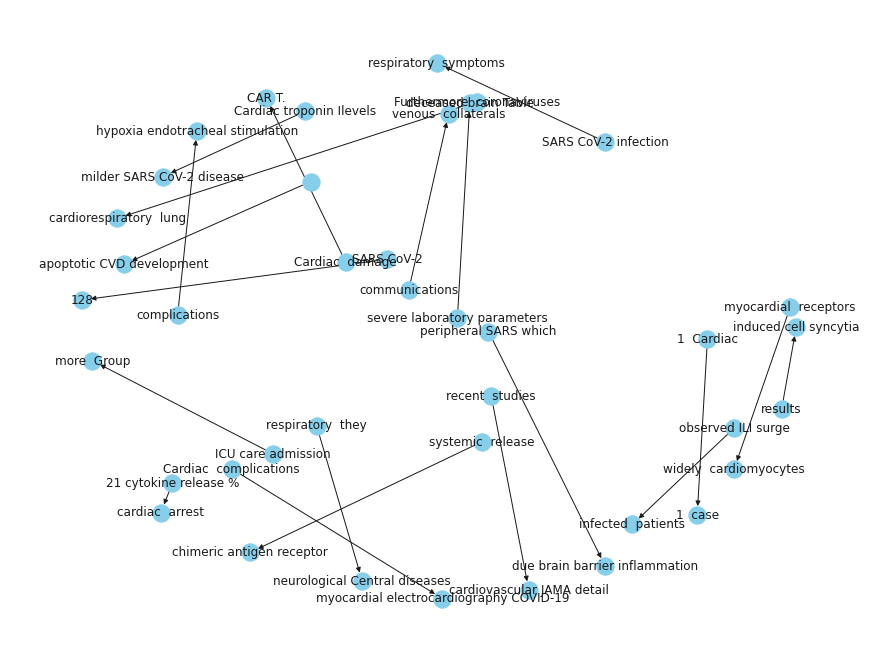

In [46]:
file_to_read = '/content/drive/My Drive/Thesis/finalreport/interesting_papers_based_on_comb_text.txt'
content = None
with open(file_to_read) as f:
    content = f.readlines()
content = [x.strip() for x in content] 
content = [string for string in content if string != ""]
top_results = content[0:100] # Select the first n elements.
selected_top_sentences = []
for elem in top_results:
    if elem.startswith('Important sentence:'):
        selected_top_sentences.append(elem.replace('Important sentence:','').strip())
# Select the first n sentences.
selected_top_sentences = selected_top_sentences[0:20]

# Some settings for the plot.
pd.set_option('display.max_colwidth', 200)

# The main idea is to go through a sentence and extract the subject and the object 
# as and when they are encountered.
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""
    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence
    prefix = ""
    modifier = ""
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text
            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text
            ## chunk 5
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    return [ent1.strip(), ent2.strip()]

# Relation/Predicate Extraction.
def get_relation(sent):
  doc = nlp(sent)
  # Matcher class object
  matcher = Matcher(nlp.vocab)
  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]
  matcher.add("matching_1", None, pattern)
  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]]
  return(span.text)

entity_pairs = []

for i in tqdm(selected_top_sentences):
  entity_pairs.append(get_entities(i))

# extract relationship
relations = [get_relation(i) for i in tqdm(selected_top_sentences)]
print(relations)

# extract subject
source = [i[0] for i in entity_pairs]
print(source)

# extract object
target = [i[1] for i in entity_pairs]
print(target)

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# Use the library networkx to build graph.
# Create a directed graph from the dataframe first.
sentence_graph = nx.from_pandas_edgelist(kg_df, 
                                         "source", 
                                         "target",
                                         edge_attr=True, 
                                         create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,9)) # Change this to make plotting area for knowledge graph bigger or smaller.
#pos = nx.spring_layout(sentence_graph)
pos = nx.spring_layout(sentence_graph,
                      k = 1.3,
                      iterations = 100,
                      fixed = None,
                      center = (0,0),
                      scale = 4)
nx.draw(sentence_graph, 
        with_labels=True, 
        node_color='skyblue', 
        edge_cmap=plt.cm.Blues, 
        pos=pos)
plt.show()